In [14]:
!nvidia-smi

Wed Mar 26 19:03:50 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     On   | 00000000:12:00.0 Off |                  N/A |
| 78%   86C    P0   111W / 125W |   6828MiB /  7982MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 4000     On   | 00000000:86:00.0 Off |                  N/A |
| 82%   

In [1]:
import zipfile
import os
import unicodedata
import regex as re
import pandas as pd
from imblearn.over_sampling import SMOTE
from pyvi import ViTokenizer, ViPosTagger
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [191]:
# zip_path = '/home/student11/ds/NLP/raw-data.zip'

# extract_to = os.path.dirname(zip_path)
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [2]:
vowel_with_accent = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                     ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                     ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                     ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                     ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                     ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                     ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                     ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                     ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                     ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                     ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                     ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

tone_marks = ['', 'f', 's', 'r', 'x', 'j']
vowel_to_ids = {}

for i in range(len(vowel_with_accent)):
    for j in range(len(vowel_with_accent[i]) - 1):
        vowel_to_ids[vowel_with_accent[i][j]] = (i, j)

def normalize_unicode(text):
    return unicodedata.normalize('NFC', text)

def normalize_vietnamese_tone(word):
    if not is_valid_vietnamese_word(word):
        return word

    chars = list(word)
    tone = 0
    vowel_indices = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowel_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check "qu"
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check "gi"
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            tone = y
            chars[index] = vowel_with_accent[x][0]
        if not qu_or_gi or index != 1:
            vowel_indices.append(index)

    if len(vowel_indices) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowel_to_ids.get(chars[1])
                chars[1] = vowel_with_accent[x][tone]
            else:
                x, y = vowel_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = vowel_with_accent[x][tone]
                else:
                    chars[1] = vowel_with_accent[5][tone] if chars[1] == 'i' else vowel_with_accent[9][tone]
            return ''.join(chars)
        return word

    for index in vowel_indices:
        x, y = vowel_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowel_with_accent[x][tone]
            return ''.join(chars)

    if len(vowel_indices) == 2:
        if vowel_indices[-1] == len(chars) - 1:
            x, y = vowel_to_ids[chars[vowel_indices[0]]]
            chars[vowel_indices[0]] = vowel_with_accent[x][tone]
        else:
            x, y = vowel_to_ids[chars[vowel_indices[1]]]
            chars[vowel_indices[1]] = vowel_with_accent[x][tone]
    else:
        x, y = vowel_to_ids[chars[vowel_indices[1]]]
        chars[vowel_indices[1]] = vowel_with_accent[x][tone]

    return ''.join(chars)

def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_index = -1
    for index, char in enumerate(chars):
        x, y = vowel_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_index == -1:
                vowel_index = index
            else:
                if index - vowel_index != 1:
                    return False
                vowel_index = index
    return True

def normalize_vietnamese_sentence(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([\p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = normalize_vietnamese_tone(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def segment_vietnamese_words(text):
    return ViTokenizer.tokenize(text)

def convert_to_lowercase(text):
    return text.lower()

def clean_text(text):
    text = re.sub(r'\b\d+\b', ' ', text)
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def process_vietnamese_text(text):
    text = normalize_unicode(text)
    text = normalize_vietnamese_sentence(text)
    text = segment_vietnamese_words(text)
    text = convert_to_lowercase(text)
    text = clean_text(text)
    return text

list_name_categories = os.listdir("/home/student11/ds/NLP/raw-data/10-topics/Test_Full")

def get_list_content(path, stopword_path="stopword.txt"):
	list_content_file = []
	list_name_file = os.listdir(path)

	with open(stopword_path, "r", encoding="utf-8") as f:
		stopwords = set(f.read().splitlines())

	for name_file in list_name_file:
		path_file = path + "/" + name_file
		with open(path_file, "r", encoding="utf-16") as file:
			content_file = file.read()
			content_file = process_vietnamese_text(content_file) 
			
			tokens = content_file.split()
			tokens = [t for t in tokens if t not in stopwords]
			content_file = " ".join(tokens)

			list_content_file.append(content_file)

	return list_content_file

def write_file_output(list_content_file, category, isTrain):
    import os

    path_file = ""
    if isTrain:
        path_file = f"clean-data/train/{category}.txt"
    else:
        path_file = f"clean-data/test/{category}.txt"

    os.makedirs(os.path.dirname(path_file), exist_ok=True)

    with open(path_file, "w", encoding="utf-8") as file_output:
        for content_file in list_content_file:
            file_output.write(content_file + "\n")

    print(f"✅ Wrote {len(list_content_file)} docs to: {path_file}")

def standardize_all_categories(train_or_test):
	for name_categories in list_name_categories : 
		path_file_output = "raw-data/" + train_or_test + "/" + name_categories
		list_content_file = get_list_content(path_file_output)	

		if train_or_test == "10-topics/Train_Full":
			write_file_output(list_content_file, name_categories, True)
		else :
			write_file_output(list_content_file, name_categories, False)

In [3]:
def get_folder_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                if not os.path.islink(filepath):
                    total_size += os.path.getsize(filepath)
            except Exception as e:
                print(f"Error with file {filepath}: {e}")
    return total_size

folder_path = '/home/student11/ds/NLP/raw-data'
size_in_bytes = get_folder_size(folder_path)
size_in_mb = size_in_bytes / (1024 * 1024)

print(f"Size of folder '{folder_path}': {size_in_mb:.2f} MB")

Size of folder '/home/student11/ds/NLP/raw-data': 483.78 MB


In [4]:
file_path = '/home/student11/ds/NLP/vectorized_train.csv'  

size_in_bytes = os.path.getsize(file_path)
size_in_mb = size_in_bytes / (1024 * 1024)

print(f"File size: {size_in_mb:.2f} MB")

File size: 361.04 MB


## Pipeline preprocess

##### Input: Raw text data from Vietnamese news sources

Preprocessing:

* Unicode normalization

* Lowercasing

* Stopword removal

* Tokenization

* Dictionary construction from training data

* TF-IDF vectorization

* Dimensionality reduction by choosing top K tokens

* Final format: TF-IDF vectors ready for training with a TensorFlow NN

In [ ]:
## Standardize

def standardize_text(text: str) -> str:
    return process_vietnamese_text(text)

In [ ]:
## Build Dictionary

def build_dictionary(train_folder: str) -> dict:
    dictionary = {}
    for filename in os.listdir(train_folder):
        with open(os.path.join(train_folder, filename), "r", encoding="utf-8") as f:
            data = f.read()
            words = re.split(r"[ \n]", data)
            for word in words:
                if word:
                    dictionary[word] = dictionary.get(word, 0) + 1
    return dictionary

In [ ]:
## Remove Stopwords + Numbers
def is_numeric_token(token):
    return bool(re.search(r'\d', token))

def filter_dictionary(dictionary: dict, stopword_path="stopword.txt", min_freq=30) -> dict:
    with open(stopword_path, "r", encoding="utf-8") as f:
        stopwords = set(f.read().splitlines())

    filtered = {
        word: freq
        for word, freq in dictionary.items()
        if word not in stopwords
        and freq >= min_freq
        and not is_numeric_token(word)  
    }
    return filtered

def remove_stopwords_from_text(text: str, stopword_path="stopword.txt") -> str:
    with open(stopword_path, "r", encoding="utf-8") as f:
        stopwords = set(f.read().splitlines())

    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return ' '.join(filtered_tokens)

In [ ]:
## Save Dictionary

def save_dictionary(dictionary: dict, save_path="dictionary.txt"):
    with open(save_path, "w", encoding="utf-8") as f:
        for word, freq in dictionary.items():
            f.write(f"{word} {freq}\n")

In [ ]:
## Load Dictionary (keys only)

def load_dict_keys(path="dictionary.txt") -> list:
    with open(path, "r", encoding="utf-8") as f:
        lines = f.read().splitlines()
        keys = [line.split(" ")[0] for line in lines if line]
    return keys

In [ ]:
## TF-IDF 

def get_tfidf_transformer(corpus: list[str], vocab: list[str]):
    cv = CountVectorizer(vocabulary=vocab)
    word_count_vector = cv.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    return cv, tfidf_transformer
def compute_tfidf_vector(text: str, cv, tfidf_transformer, vocab: list[str]) -> dict:
    vector = cv.transform([text])
    tfidf = tfidf_transformer.transform(vector)
    return dict(zip(vocab, tfidf.toarray()[0]))

In [11]:
def preprocess_pipeline(raw_train_dir="raw-data/10-topics/Train_Full",
                        raw_test_dir="raw-data/10-topics/Test_Full",
                        clean_base_dir="clean-data",
                        top_k=2500):
    for path, is_train in [(raw_train_dir, True), (raw_test_dir, False)]:
        category_dirs = os.listdir(path)
        for category in category_dirs:
            category_path = os.path.join(path, category)
            texts = get_list_content(category_path)
            write_file_output(texts, category, isTrain=is_train)

    dictionary = build_dictionary(os.path.join(clean_base_dir, "train"))
    dictionary = filter_dictionary(dictionary)
    
    top_words = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_dict = dict(top_words)
    save_dictionary(top_dict)

    vocab = list(top_dict.keys())
    corpus = []
    for fname in os.listdir(os.path.join(clean_base_dir, "train")):
        with open(os.path.join(clean_base_dir, "train", fname), "r", encoding="utf-8") as f:
            corpus.extend(f.read().splitlines())

    cv, tfidf = get_tfidf_transformer(corpus, vocab)

    print("✅ Preprocessing complete. TF-IDF vectorizer and dictionary ready.")
    return cv, tfidf, vocab

In [12]:
cv, tfidf, vocab = preprocess_pipeline()

✅ Wrote 3868 docs to: clean-data/train/Phap luat.txt
✅ Wrote 5298 docs to: clean-data/train/The thao.txt
✅ Wrote 3384 docs to: clean-data/train/Suc khoe.txt
✅ Wrote 1820 docs to: clean-data/train/Khoa hoc.txt
✅ Wrote 2481 docs to: clean-data/train/Vi tinh.txt
✅ Wrote 2552 docs to: clean-data/train/Kinh doanh.txt
✅ Wrote 3159 docs to: clean-data/train/Doi song.txt
✅ Wrote 3080 docs to: clean-data/train/Van hoa.txt
✅ Wrote 2898 docs to: clean-data/train/The gioi.txt
✅ Wrote 5219 docs to: clean-data/train/Chinh tri Xa hoi.txt
✅ Wrote 3788 docs to: clean-data/test/Phap luat.txt
✅ Wrote 6667 docs to: clean-data/test/The thao.txt
✅ Wrote 5417 docs to: clean-data/test/Suc khoe.txt
✅ Wrote 2096 docs to: clean-data/test/Khoa hoc.txt
✅ Wrote 4560 docs to: clean-data/test/Vi tinh.txt
✅ Wrote 5276 docs to: clean-data/test/Kinh doanh.txt
✅ Wrote 2036 docs to: clean-data/test/Doi song.txt
✅ Wrote 6250 docs to: clean-data/test/Van hoa.txt
✅ Wrote 6716 docs to: clean-data/test/The gioi.txt
✅ Wrote 756

In [13]:
len(vocab)

2500

In [51]:
def load_clean_data_as_df(folder: str) -> pd.DataFrame:
    data = []
    for filename in os.listdir(folder):
        label = os.path.splitext(filename)[0]  
        filepath = os.path.join(folder, filename)

        with open(filepath, "r", encoding="utf-8") as f:
            for line in f:
                text = line.strip()
                if text:
                    data.append((text, label))

    df = pd.DataFrame(data, columns=["text", "label"])
    return df
def vectorize_dataframe(df: pd.DataFrame, cv, tfidf) -> pd.DataFrame:
    tfidf_matrix = tfidf.transform(cv.transform(df["text"]))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=cv.get_feature_names_out())
    tfidf_df["label"] = df["label"].values
    return tfidf_df

In [52]:
train_df = load_clean_data_as_df("clean-data/train")
test_df = load_clean_data_as_df("clean-data/test")
train_df.head(5)

,text,label
0,cơn_sốt tiêu_dùng mùa giáng_sinh châu đạo thiê...,The gioi
1,dân syria phóng_hỏa tòa đại_sứ na uy đan mạch ...,The gioi
2,chết nổi khuôn_mặt bầu_bĩnh mèo nổi_tiếng truy...,The gioi
3,con_tin iraq philippines văn_phòng lao_động vi...,The gioi
4,tổng_thống mỹ đe_dọa syria iraq george bush hô...,The gioi


In [ ]:
# train_df.to_csv("train.csv", index=False)
# test_df.to_csv("test.csv", index=False)

In [53]:
vectorized_train = vectorize_dataframe(train_df, cv, tfidf)
vectorized_test = vectorize_dataframe(test_df, cv, tfidf)

vectorized_train.head(5)

,hai,đi,đội,mỹ,nguyễn,đồng,nam,tiền,công_ty,trận,...,tán,động_lực,nhi,phì,tạt,đánh_dấu,baghdad,hiệp_định,tiến_độ,label
0,0.000000,0.013096,0.00000,0.000000,0.0,0.0,0.000000,0.035230,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036008,0.0,0.0,0.0,The gioi
1,0.075031,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,The gioi
2,0.051316,0.070741,0.02602,0.117143,0.0,0.0,0.000000,0.095155,0.098498,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,The gioi
3,0.000000,0.000000,0.00000,0.028265,0.0,0.0,0.026931,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,The gioi
4,0.000000,0.000000,0.00000,0.264486,0.0,0.0,0.000000,0.044758,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,The gioi


In [54]:
X_train = vectorized_train.drop(columns=['label'])
y_train = vectorized_train['label']

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_encoded)

y_resampled = encoder.inverse_transform(y_resampled)

train_balanced = pd.DataFrame(X_resampled, columns=X_train.columns)
train_balanced['label'] = y_resampled

print("Train sau khi SMOTE:")
print(train_balanced['label'].value_counts())

Train sau khi SMOTE:
label
The gioi            5298
Suc khoe            5298
Vi tinh             5298
Phap luat           5298
Doi song            5298
Chinh tri Xa hoi    5298
The thao            5298
Van hoa             5298
Khoa hoc            5298
Kinh doanh          5298
Name: count, dtype: int64


/tmp/ipykernel_1584289/2292150198.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_balanced['label'] = y_resampled


In [55]:
train_balanced.to_csv("vectorized_train_balanced.csv", index=False)
vectorized_test.to_csv("vectorized_test.csv", index=False)

In [56]:
with open("vectorizer.pkl", "wb") as f:
    pickle.dump((cv, tfidf), f)

In [57]:
vectorized_train.to_csv('vectorized_train.csv', index = False)

---

### Data analysis post-vectorization

In [ ]:
train_df = pd.read_csv("/home/student11/ds/NLP/vectorized_train.csv")
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]
test_df = pd.read_csv("/home/student11/ds/NLP/vectorized_test.csv")
X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

with open("/home/student11/ds/NLP/vectorizer.pkl", "rb") as f:
    cv, tfidf = pickle.load(f)

In [4]:
len(y_train.unique())

10

In [5]:
len(y_test.unique())

10

/tmp/ipykernel_1584289/1822271361.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms[cls].values, y=top_terms[cls].index, ax=axes[i], palette="Blues_d")
/tmp/ipykernel_1584289/1822271361.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms[cls].values, y=top_terms[cls].index, ax=axes[i], palette="Blues_d")
/tmp/ipykernel_1584289/1822271361.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms[cls].values, y=top_terms[cls].index, ax=axes[i], palette="Blues_d")
/tmp/ipykernel_1584289/1822271361.py:19: Futur

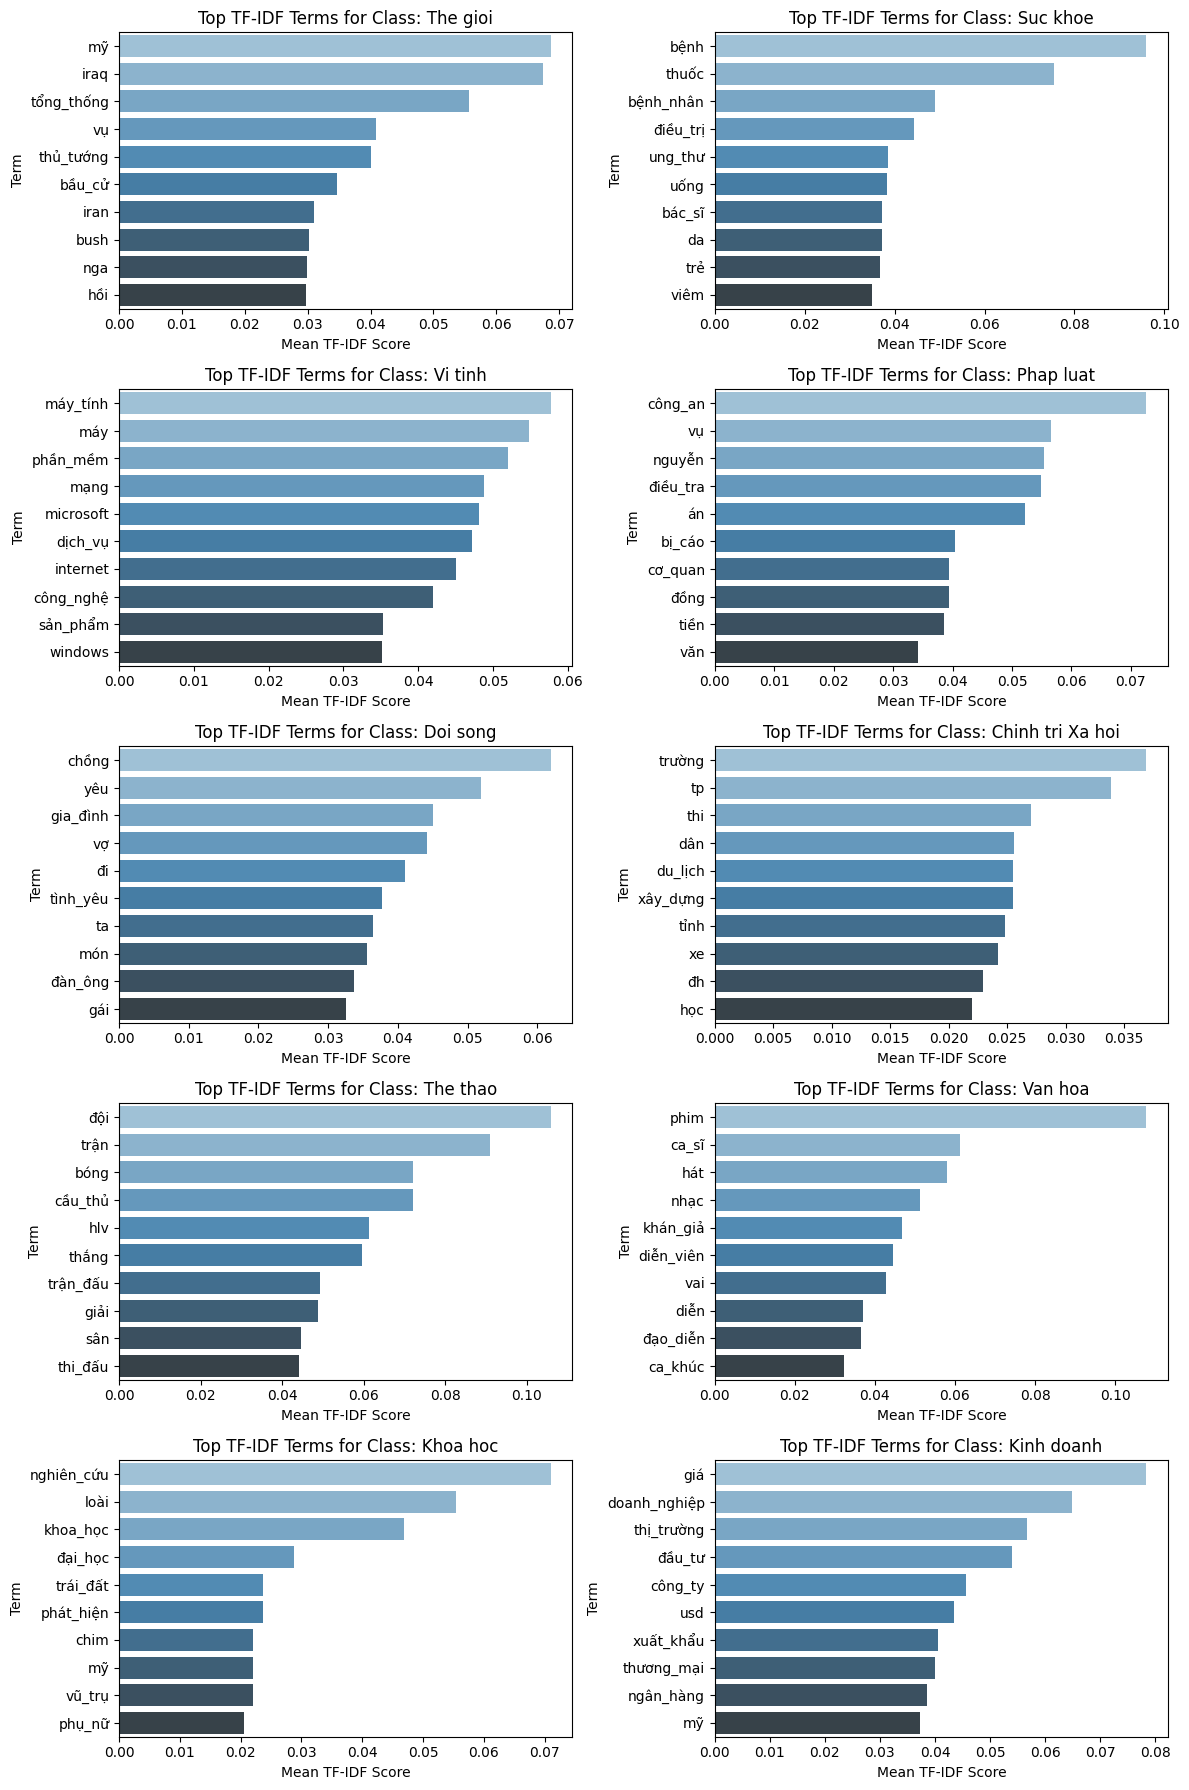

In [59]:
feature_names = cv.get_feature_names_out()
classes = y_train.unique()
class_tfidf = {}

for cls in classes:
    cls_indices = y_train == cls
    cls_matrix = X_train[cls_indices]
    cls_means = cls_matrix.mean()
    class_tfidf[cls] = pd.Series(cls_means.values, index=cls_matrix.columns)

top_terms = {}
for cls in classes:
    top_terms[cls] = class_tfidf[cls].sort_values(ascending=False).head(10)

fig, axes = plt.subplots(5, 2, figsize=(12, 18))
axes = axes.flatten()

for i, cls in enumerate(classes):
    sns.barplot(x=top_terms[cls].values, y=top_terms[cls].index, ax=axes[i], palette="Blues_d")
    axes[i].set_title(f"Top TF-IDF Terms for Class: {cls}")
    axes[i].set_xlabel("Mean TF-IDF Score")
    axes[i].set_ylabel("Term")

plt.tight_layout()

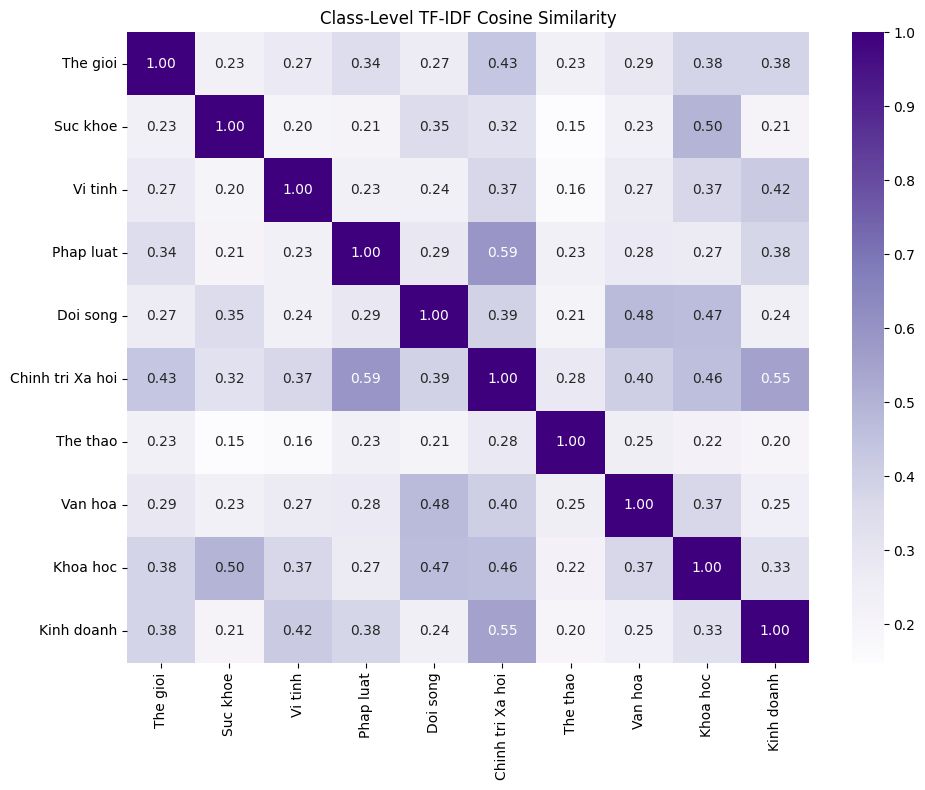

In [ ]:
class_vectors = {}
for cls in y_train.unique():
    class_vectors[cls] = X_train[y_train == cls].mean().values

class_df = pd.DataFrame(class_vectors).T  
similarity_matrix = cosine_similarity(class_df)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix,
            xticklabels=class_df.index,
            yticklabels=class_df.index,
            cmap = 'Purples',
            annot=True,
            fmt=".2f")
plt.title("Class-Level TF-IDF Cosine Similarity")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

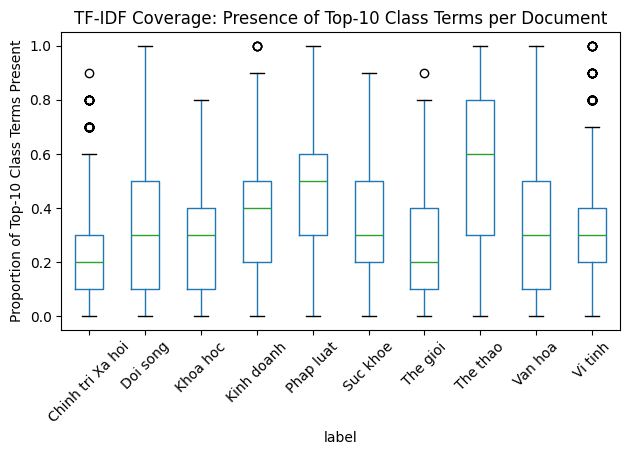

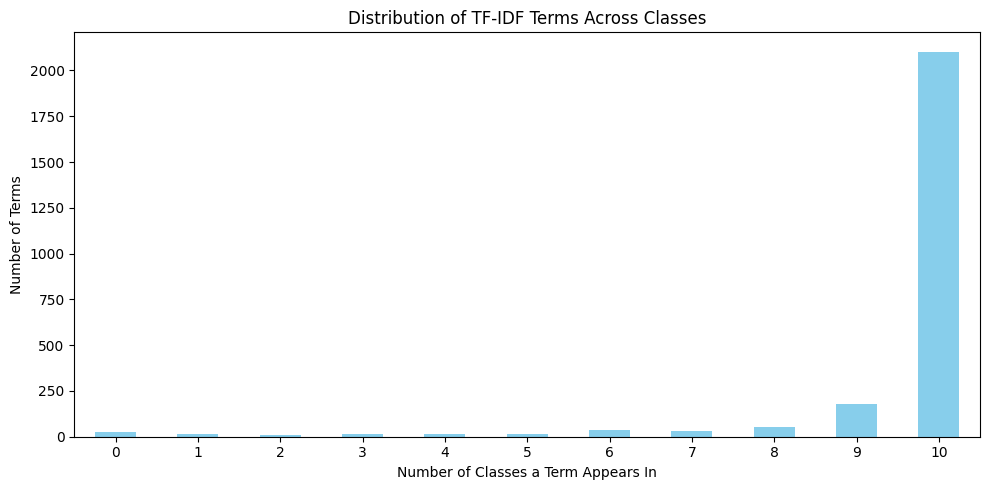

In [28]:
# --- Per-class TF-IDF Coverage ---
top_k = 10
coverage_ratios = []

top_terms_per_class = {
    cls: X_train[y_train == cls].mean().sort_values(ascending=False).head(top_k).index.tolist()
    for cls in y_train.unique()
}

for idx, row in X_train.iterrows():
    label = y_train.iloc[idx]
    top_terms = top_terms_per_class[label]
    doc_tfidf = row[top_terms]
    coverage = (doc_tfidf > 0).sum() / top_k
    coverage_ratios.append((label, coverage))

coverage_df = pd.DataFrame(coverage_ratios, columns=["label", "coverage_ratio"])

plt.figure(figsize=(12, 6))
coverage_df.boxplot(by="label", column="coverage_ratio", grid=False, rot=45)
plt.title("TF-IDF Coverage: Presence of Top-10 Class Terms per Document")
plt.ylabel("Proportion of Top-10 Class Terms Present")
plt.suptitle("")
plt.tight_layout()
plt.show()

# --- Term-Class Spread Histogram ---

term_class_counts = pd.Series(0, index=X_train.columns)

for cls in y_train.unique():
    class_terms = X_train[y_train == cls].mean()
    term_class_counts += (class_terms > 0).astype(int)

plt.figure(figsize=(10, 5))
term_class_counts.value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of TF-IDF Terms Across Classes")
plt.xlabel("Number of Classes a Term Appears In")
plt.ylabel("Number of Terms")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

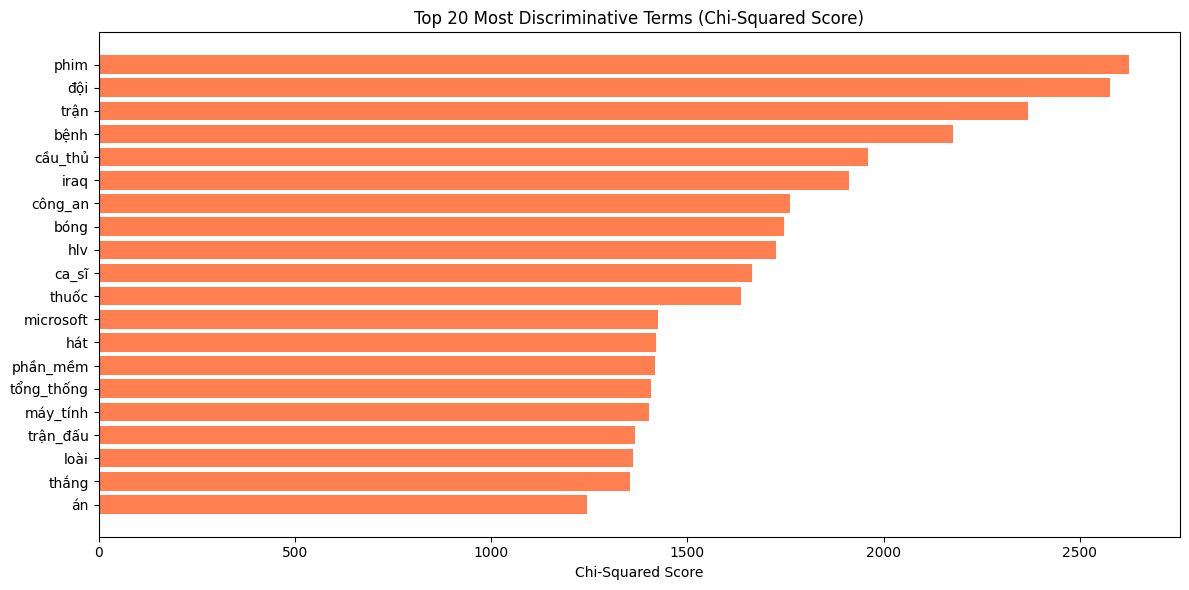

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

chi2_scores, p_values = chi2(X_train, y_encoded)

chi2_df = pd.DataFrame({
    "term": X_train.columns,
    "chi2_score": chi2_scores,
    "p_value": p_values
}).sort_values(by="chi2_score", ascending=False)

top_k = 20
plt.figure(figsize=(12, 6))
plt.barh(chi2_df["term"].head(top_k)[::-1], chi2_df["chi2_score"].head(top_k)[::-1], color="coral")
plt.title("Top 20 Most Discriminative Terms (Chi-Squared Score)")
plt.xlabel("Chi-Squared Score")
plt.tight_layout()
plt.show()

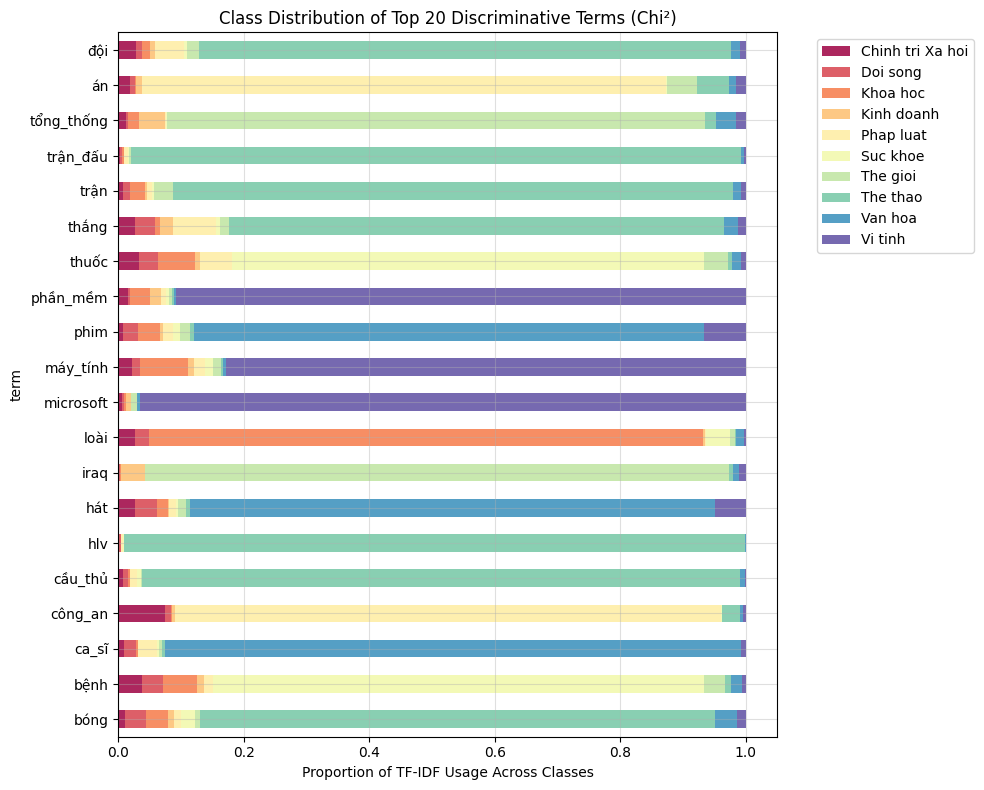

In [39]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
class_names = le.classes_

chi2_scores, _ = chi2(X_train, y_encoded)
chi2_df = pd.DataFrame({"term": X_train.columns, "chi2_score": chi2_scores})
top_terms = chi2_df.sort_values(by="chi2_score", ascending=False).head(20)["term"]

term_class_contributions = []

for term in top_terms:
    for cls in class_names:
        mean_score = X_train[y_train == cls][term].mean()
        term_class_contributions.append((term, cls, mean_score))

term_class_df = pd.DataFrame(term_class_contributions, columns=["term", "class", "mean_tfidf"])

term_class_df["normalized"] = term_class_df.groupby("term")["mean_tfidf"].transform(lambda x: x / x.sum())

pivot_df = term_class_df.pivot(index="term", columns="class", values="normalized").fillna(0)

pivot_df.plot(kind="barh", stacked=True, figsize=(10, 8), colormap="Spectral", alpha=0.85)
plt.title("Class Distribution of Top 20 Discriminative Terms (Chi²)")
plt.xlabel("Proportion of TF-IDF Usage Across Classes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha = 0.4)
plt.show()

---